# MNIST Dataset

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

In [10]:
# Importing input_data
mnist = input_data.read_data_sets(train_dir='data/', one_hot=True)
print(mnist.train.num_examples)
print(mnist.test.num_examples)
print(mnist.validation.num_examples)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
55000
10000
5000


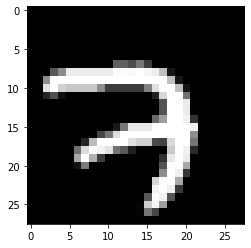

In [11]:
plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='gist_gray')

## Simple ANN

In [12]:
# Placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 784))
y_true = tf.placeholder(dtype=tf.float32, shape=(None, 10))

# Variables
W = tf.Variable(initial_value=tf.zeros(shape=(784, 10)))
b = tf.Variable(initial_value=tf.zeros(shape=(10)))

# Operations
y = tf.matmul(x, W) + b

# Loss Functions
cross_entropy = tf.reduce_mean(
    input_tensor=tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_true, 
        logits=y
    )
)

# Optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)
train = optimizer.minimize(cross_entropy)

In [15]:
# Create and Run Session
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for step in range(1000):
        if step % 500 == 0:
            print(step,'/1000')
        batch_x, batch_y = mnist.train.next_batch(batch_size=100)
        sess.run(train, feed_dict={x: batch_x, y_true:batch_y})
        
    correct_prediction = tf.equal(
        tf.argmax(y, axis=1), 
        tf.argmax(y_true, axis=1)
    )
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    print(sess.run(
        acc, 
        feed_dict={x:mnist.test.images, y_true:mnist.test.labels}
    ))

0 /1000
500 /1000
0.918


## CNN

In [28]:
# Helper functions
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=1, padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(
        value=x, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], 
        padding='SAME'
    )

def conv_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def dense_layer(input_layer, size):
    input_size = int(input_layer.shape[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [30]:
# Placeholders
x = tf.placeholder(tf.float32, shape=(None, 784))
y_true = tf.placeholder(tf.float32, shape=(None, 10))
dropout_prob = tf.placeholder(tf.float32)

x_img = tf.reshape(x, [-1, 28, 28, 1])

# Layers
conv_1 = conv_layer(x_img, shape=[5, 5, 1, 32])
conv_1_maxpool = max_pool_2by2(conv_1)
conv_2 = conv_layer(conv_1_maxpool, shape=[5, 5, 32, 64])
conv_2_maxpool = max_pool_2by2(conv_2)
conv_2_flat = tf.reshape(conv_2_maxpool, shape=[-1, 7 * 7 * 64])
dense_1 = tf.nn.relu(dense_layer(conv_2_flat, size=1024))
dense_1_dropout = tf.nn.dropout(dense_1, rate=dropout_prob)
y_pred = dense_layer(dense_1_dropout, size=10)

# Losses
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_true,
        logits=y_pred
    )
)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [36]:
steps = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        batch_x, batch_y = mnist.train.next_batch(50)
        sess.run(train, feed_dict={x:batch_x, y_true:batch_y, dropout_prob:0.5})
        if (i + 1) % 10 == 0:
            matches = tf.equal(
                tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1)
            )
            accuracy = sess.run(
                tf.reduce_mean(
                    tf.cast(matches, tf.float32)
                ), 
                feed_dict={
                    x:mnist.test.images, 
                    y_true:mnist.test.labels,
                    dropout_prob:0.0
                }
            )
            print('On step: {}'.format(i + 1))
            print('Accuracy: {}'.format(accuracy))
    print('Final Accuracy: {}%'.format(accuracy * 100))

On step: 10
Accuracy: 0.47350001335144043
On step: 20
Accuracy: 0.6651999950408936
On step: 30
Accuracy: 0.8331000208854675
On step: 40
Accuracy: 0.8736000061035156
On step: 50
Accuracy: 0.9049999713897705
On step: 60
Accuracy: 0.9136000275611877
On step: 70
Accuracy: 0.9229999780654907
On step: 80
Accuracy: 0.9381999969482422
On step: 90
Accuracy: 0.940500020980835
On step: 100
Accuracy: 0.941100001335144
Final Accuracy: 94.1100001335144%
